In [13]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import load_model
from visualization.plot_lib import DataView
from preprocessing.data import DataTransformer
from model.gru import GRUModel
import math

In [14]:
df = pd.read_csv("./data/prices-split-adjusted.csv", index_col = 0)
df.head()

,symbol,open,close,low,high,volume
date,,,,,,
2016-01-05,WLTW,123.430000,125.839996,122.309998,126.250000,2163600.0
2016-01-06,WLTW,125.239998,119.980003,119.940002,125.540001,2386400.0
2016-01-07,WLTW,116.379997,114.949997,114.930000,119.739998,2489500.0
2016-01-08,WLTW,115.480003,116.620003,113.500000,117.440002,2006300.0
2016-01-11,WLTW,117.010002,114.970001,114.089996,117.330002,1408600.0


In [15]:
df.describe()

,open,close,low,high,volume
count,851264.000000,851264.000000,851264.000000,851264.000000,8.512640e+05
mean,64.993618,65.011913,64.336541,65.639748,5.415113e+06
std,75.203893,75.201216,74.459518,75.906861,1.249468e+07
min,1.660000,1.590000,1.500000,1.810000,0.000000e+00
25%,31.270000,31.292776,30.940001,31.620001,1.221500e+06
50%,48.459999,48.480000,47.970001,48.959999,2.476250e+06
75%,75.120003,75.139999,74.400002,75.849998,5.222500e+06
max,1584.439941,1578.130005,1549.939941,1600.930054,8.596434e+08


In [16]:
df = df[df["symbol"] == "AMZN"]
df.drop(["symbol"], 1, inplace = True)

df["adj_close"] = df.close
df.drop(["close"], 1, inplace=True)

In [17]:
df.head()

,open,low,high,volume,adj_close
date,,,,,
2010-01-04,136.250000,133.139999,136.610001,7599900.0,133.899994
2010-01-05,133.429993,131.809998,135.479996,8851900.0,134.690002
2010-01-06,134.600006,131.649994,134.729996,7178800.0,132.250000
2010-01-07,132.009995,128.800003,132.320007,11030200.0,130.000000
2010-01-08,130.559998,129.029999,133.679993,9830500.0,133.520004


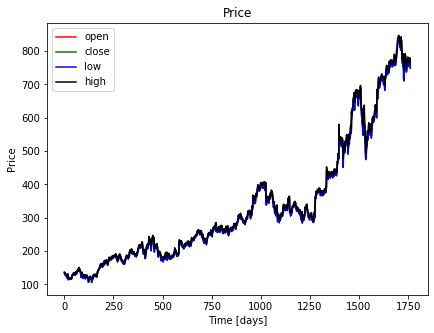

In [18]:
DataView.plot_variables(df)

In [19]:
satationary_df = DataTransformer.stationary_data(df, ["open", "adj_close", "low", "high", "volume"])
satationary_df.describe()

,open,low,high,volume,adj_close
count,1761.000000,1761.000000,1761.000000,1761.000000,1761.000000
mean,0.000981,0.000980,0.000980,-0.000347,0.000978
std,0.020432,0.019296,0.018137,0.375122,0.020324
min,-0.158147,-0.139335,-0.140989,-1.564264,-0.135325
25%,-0.008883,-0.007533,-0.007383,-0.231667,-0.009201
50%,0.000782,0.001515,0.000162,-0.027677,0.000577
75%,0.011384,0.009653,0.008987,0.206599,0.012175
max,0.163498,0.131833,0.166223,1.439482,0.146225


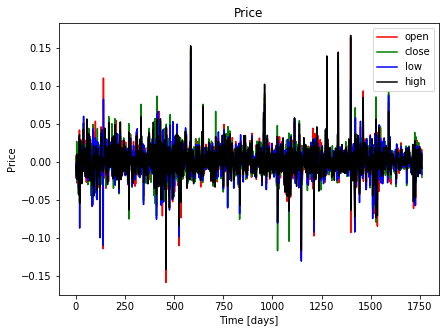

In [20]:
DataView.plot_variables(satationary_df)

In [21]:
amount_of_features = len(df.columns)
seq_len = 30

train, test = DataTransformer.split_data(df.values)
train, test = DataTransformer.normalize_data(train, test)

x_train, y_train = DataTransformer.formate_data(train, amount_of_features, seq_len)
x_test, y_test = DataTransformer.formate_data(test, amount_of_features, seq_len)

print("Train set examples (x): ", x_train.shape[0])
print("Train set examples (y): ", y_train.shape[0])

print("Test set examples (x): ", x_test.shape[0])
print("Test set examples (y): ", y_test.shape[0])


Train set examples (x):  1379
Train set examples (y):  1379
Test set examples (x):  321
Test set examples (y):  321


In [22]:
gru_model = GRUModel()
model = gru_model.build(amount_of_features, seq_len)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_2 (GRU)                  (None, 30, 256)           201216    
_________________________________________________________________
gru_3 (GRU)                  (None, 256)               393984    
_________________________________________________________________
dense_2 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 611,713
Trainable params: 611,713
Non-trainable params: 0
_________________________________________________________________


In [23]:
epochs = 80
batch_size = 1024

In [24]:
history = gru_model.train_model(
    model, 
    x_train, 
    y_train, 
    batch_size,
    epochs, 
    "./data/gru-model")

Train on 1241 samples, validate on 138 samples
Epoch 1/80
1241/1241 [==============================] - 14s 11ms/sample - loss: 0.3845 - val_loss: 0.1029
Epoch 2/80
1241/1241 [==============================] - 7s 5ms/sample - loss: 0.0636 - val_loss: 0.0500
Epoch 3/80
1241/1241 [==============================] - 8s 6ms/sample - loss: 0.1377 - val_loss: 0.0991
Epoch 4/80
1241/1241 [==============================] - 8s 6ms/sample - loss: 0.1368 - val_loss: 0.0627
Epoch 5/80
1241/1241 [==============================] - 7s 6ms/sample - loss: 0.0240 - val_loss: 0.0430
Epoch 6/80
1241/1241 [==============================] - 7s 6ms/sample - loss: 0.0209 - val_loss: 0.0471
Epoch 7/80
1241/1241 [==============================] - 7s 6ms/sample - loss: 0.0148 - val_loss: 0.0310
Epoch 8/80
1241/1241 [==============================] - 7s 6ms/sample - loss: 0.0154 - val_loss: 0.0274
Epoch 9/80
1241/1241 [==============================] - 11s 9ms/sample - loss: 0.0133 - val_loss: 0.0230
Epoch 10/80
12

1241/1241 [==============================] - 11s 9ms/sample - loss: 0.0037 - val_loss: 0.0031
Epoch 79/80
1241/1241 [==============================] - 8s 6ms/sample - loss: 0.0033 - val_loss: 0.0120
Epoch 80/80
1241/1241 [==============================] - 8s 6ms/sample - loss: 0.0031 - val_loss: 0.0026


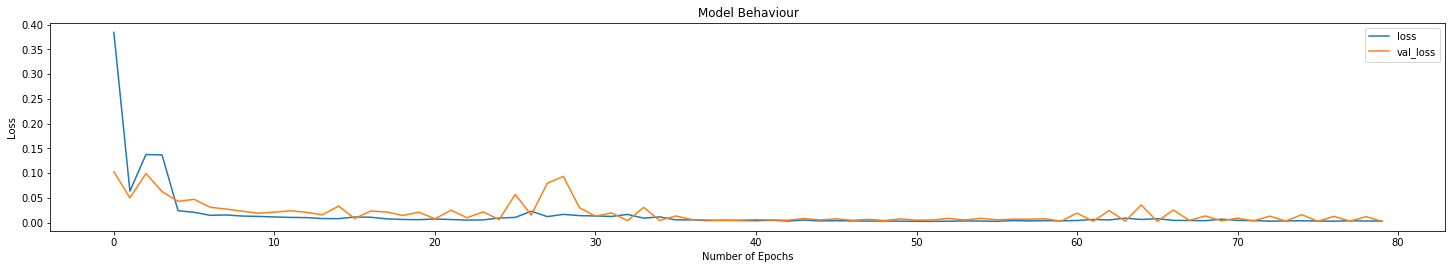

In [25]:
DataView.plot_model_loss(history)

In [26]:
model = load_model("./data/gru-model")

In [27]:
predictions = model.predict(x_test)

In [28]:
trainScore = model.evaluate(x_train, y_train, verbose=0)
print('Train Score: %.5f MSE (%.2f RMSE)' % (trainScore, math.sqrt(trainScore)))

Train Score: 0.00927 MSE (0.10 RMSE)


In [29]:
testScore = model.evaluate(x_test, y_test, verbose=0)
print('Test Score: %.5f MSE (%.2f RMSE)' % (testScore, math.sqrt(testScore)))

Test Score: 0.04479 MSE (0.21 RMSE)


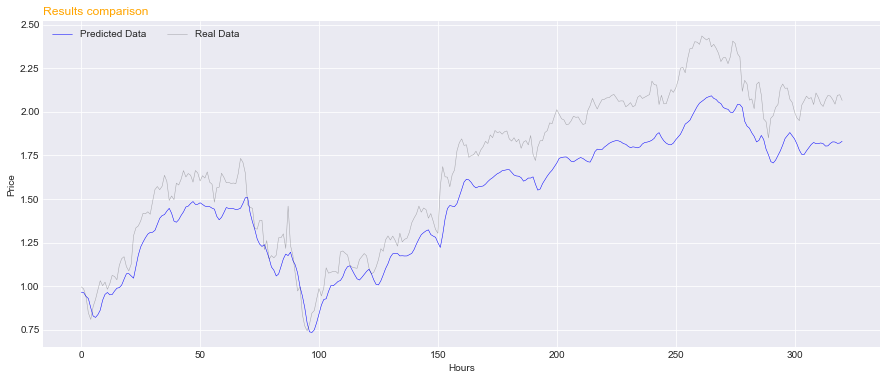

In [30]:
DataView.plot_results_against_true_data(predictions, y_test)